# 1. Imports/Setup

The work shown here presents the outcomes and resulting analysis of implementing various pricing models on the following [investment portfolio](https://docs.google.com/spreadsheets/d/1EZj5M7dXGy-48i0PydZQa5gpUOYCQHDFRBlp_rU1sdo/edit#gid=16979173). The pricing models implemented here include:

* [Volume-Weighted Average Price (VWAP)](https://www.investopedia.com/terms/a/alpha.asp)
* [Sharpe Ratio](https://www.investopedia.com/terms/s/sharperatio.asp)
* [Alpha (Capital Asset Pricing Model)](https://www.investopedia.com/terms/a/alpha.asp)

The code in the cell below provides all the libraries/setup needed to run the notebook, and defines a number of global variables utilized by the models themselves. All financial information used in this notebook was pulled via the Yahoo Finance API using the `yfinance` python package. The pertinent period for this analysis is from 2023-09-16 to 2023-10-16.

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')

RISK_FREE_RATE = 0.0471 # 10 year treasury rate as of 10/16: https://ycharts.com/indicators/10_year_treasury_rate

# 2. Collect Data

The cell below imports a .csv version of the data found in the "For Import" tab of the aforementioned investment portfolio and stores the information in the `investments` dataframe. It also calculates a weights column that determines each asset's percentage of the total portfolio by value (total portfolio value in this case is equal to 8 million USD).

In [2]:
investments = pd.read_csv('../Portfolio/investments.csv')
investments['weights'] = investments['initial_investment'] / investments['initial_investment'].sum()
portfolio_start = investments.initial_investment.sum()
investments.head()

,investment_type,GCIS_sector,name,country_of_origin,ticker,price_per_unit,initial_investment,number_of_units,weights
0,stocks,Energy,Exxon Mobil Corp,U.S.,XOM,116.70,400000,3427.592117,0.0500
1,stocks,Energy,PetroChina Co Ltd,China,PCCYF,0.66,400000,606060.606100,0.0500
2,stocks,Energy,NextEra Energy Inc.,U.S.,NEE,68.64,200000,2913.752914,0.0250
3,stocks,Materials,BHP Group Ltd,Austrailia,BHP,58.45,100000,1710.863986,0.0125
4,stocks,Materials,Air Products & Chemicals Inc,U.S.,APD,302.11,100000,331.005263,0.0125


# 3. Pricing Model: VWAP 
## 3.1. Calculate VWAP

* [Helpful resource](https://www.investing.com/academy/analysis/vwap-formula/)

The first pricing model implemented is VWAP, otherwise known as the volume weighted average price. VWAP represents a rolling average of the trading price of an an asset over the course of a single day by looking at the price and volume of said asset during different time intervals. During each time interval (usually 1 or 5 minutes), an average trading price is generated by summing the low, high, and closing price for that interval and dividing by 3. This average is then weighted by multiplying by the trading volume over the same interval. A running total of this intermediate value - known as the typical price volume (TVP) - and the trading volume are maintained over the course of each subsequent interval. To calculate the VWAP at a given time, simply divide the cumulative volume and TVP values at the given time interval. Expressed as a formula, the VWAP of the $I$th interval in a given day can be written as:

$$
\begin{equation}
\text{VWAP}_I = \frac{\sum_{i}^{I} \frac{C_i + L_i + H_i}{3} \cdot V_i}{\sum_i^I V_i}
\end{equation}
$$

where:

* $C_i$ = the closing price of the $i$th interval.
* $H_h$ = the high price of the $i$th interval.
* $L_l$ = the low price of the $i$th interval.
* $V_i$ = the trading volume of the $i$th interval.
* $\text{VWAP}_i$ = the VWAP value of the $I$th interval. 
* $i \leq I$

The cell below calculates the VWAP values for all assets in the portfolio using 5 minute intervals of each trading day between the start date (2023-09-16) and end date (2023-10-16). 

In [3]:
tickers = list(investments['ticker'].values)
start_date = dt.datetime(2023, 9, 16, 9, 30)
end_date = start_date + relativedelta(months=1)

vwaps = []
for ticker in tickers:
    print(f'Calculating VWAP for symbol {ticker}...')

    ticker_obj = yf.Ticker('XOM')
    hist_data = ticker_obj.history(start=start_date, interval='5m').reset_index()
    hist_data['Date'] = hist_data['Datetime'].dt.date

    dates = sorted(list(set(hist_data['Date'].values)))
    for date in dates:
        #print(f'Calculating VWAP for symbol {ticker} on day {date}...')
        day_df = hist_data[hist_data['Date'] == date]
        day_df['TPV'] = ((day_df['Open'] + day_df['High'] + day_df['Low']) / 3) * day_df['Volume']
        day_df['cumsum_Volume'] = day_df['Volume'].cumsum()
        day_df['cumsum_TPV'] = day_df['TPV'].cumsum()
        day_df['VWAP'] = day_df['cumsum_TPV'] / day_df['cumsum_Volume']
        day_df = day_df[['Datetime', 'Date', 'Close', 'VWAP']]
        day_df['Ticker'] = ticker
        vwaps.append(day_df)

vwaps_df = pd.concat(vwaps)

Calculating VWAP for symbol XOM...
Calculating VWAP for symbol PCCYF...
Calculating VWAP for symbol NEE...
Calculating VWAP for symbol BHP...
Calculating VWAP for symbol APD...
Calculating VWAP for symbol RTX...
Calculating VWAP for symbol UNP...
Calculating VWAP for symbol AMZN...
Calculating VWAP for symbol TSLA...
Calculating VWAP for symbol HESAY...
Calculating VWAP for symbol BUD...
Calculating VWAP for symbol PG...
Calculating VWAP for symbol HIMS...
Calculating VWAP for symbol PFE...
Calculating VWAP for symbol EL...
Calculating VWAP for symbol BRK-A...
Calculating VWAP for symbol IDCBY...
Calculating VWAP for symbol RY...
Calculating VWAP for symbol MSFT...
Calculating VWAP for symbol TCEHY...
Calculating VWAP for symbol SNOW...
Calculating VWAP for symbol GOOGL...
Calculating VWAP for symbol AMX...
Calculating VWAP for symbol NG...
Calculating VWAP for symbol IBDRY...
Calculating VWAP for symbol PLD...
Calculating VWAP for symbol PSA...
Calculating VWAP for symbol BTC-USD...
C

## 3.2. Interpret VWAP Results

VWAP is helpful in that it allows an investor to make minute-by-minute evaluations as to the true value and demand of a asset compared to its current price. Namely, if the VWAP value is above the current price for a indivual asset, it is likely in the investor's interest to buy that asset. Similarly, if the VWAP value of a given asset is below the current price, it is likely in the investor's interest to sell that asset. However, using VWAP in this way is typically only useful for investors trading on short time scales, as VWAP calculations are almost always only calculated over the course of a single trading day. That being said, the VWAP pricing model is likely to be the least informative in this case, as the portfolio being analyzed was created with the intention of providing long term growth. Despite this, we can still look at the comparisons between VWAP values and price over all the intervals and trading days to try and get an idea as to how each asset is performing. The cell below creates a histogram of all the differences between VWAP and price calculated for each interval of each day for each asset:

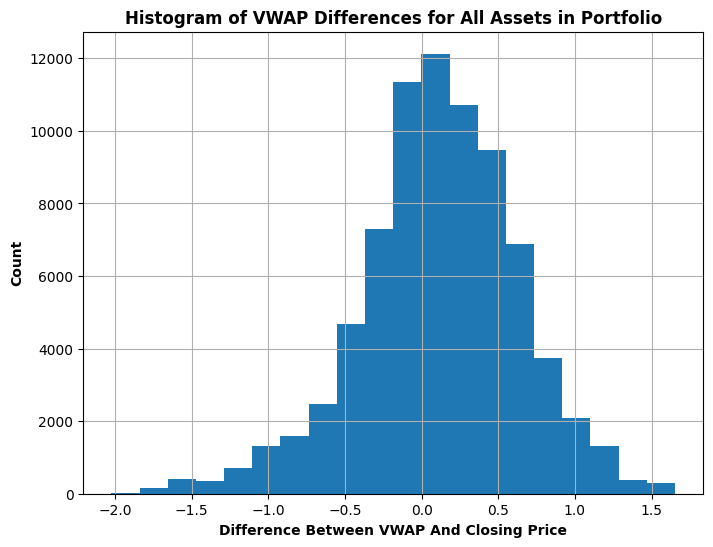

In [4]:
vwaps_df['diff'] = vwaps_df['VWAP'] - vwaps_df['Close']

plt.figure(figsize=(8, 6))

plt.hist(vwaps_df['diff'], bins=20)
plt.xlabel('Difference Between VWAP And Closing Price', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.title('Histogram of VWAP Differences for All Assets in Portfolio', fontweight='bold')
plt.grid()
plt.show()

As we can see from the plot above, the histogram is centered at 0 and appears slightly skewed to the left. It looks looks as though the values on either side of the histogram's midpoint might be equal to each other, so instead it might be more helpful to look at how often the VWAP model tells us to buy versus sell:

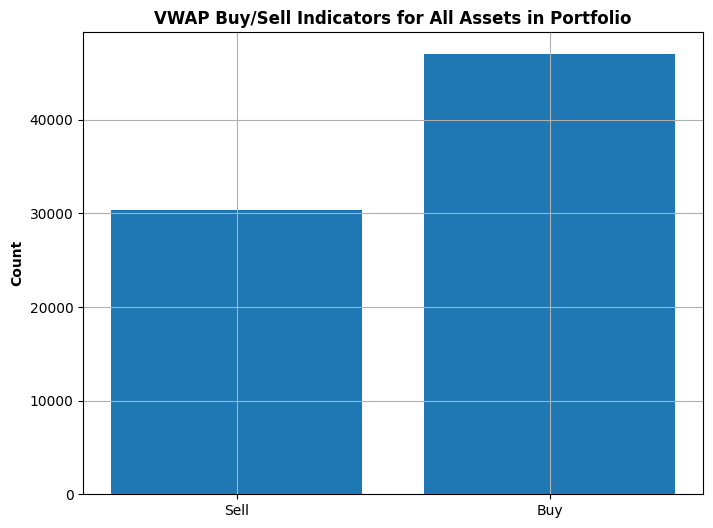

In [5]:
vwaps_df['buy'] = vwaps_df['diff'] > 0
indicators = vwaps_df['buy'].value_counts()

plt.figure(figsize=(8,6))
plt.bar(indicators.index, indicators.values)
plt.ylabel('Count', fontweight='bold')
plt.title('VWAP Buy/Sell Indicators for All Assets in Portfolio', fontweight='bold')
plt.xticks([0, 1], ['Sell', 'Buy']) 
plt.grid()
plt.show()

We can see that more often than not the VWAP pricing model indicated that we should buy assets in the portfolio compared to selling them. This might give an indication as to the potential for long-term growth, but once again VWAP is likely the least informative model for this use case and is really only helpful for short-term trading behavior. 

# 4. Pricing Model: Sharpe Ratio
## 4.1. Calculate Sharpe Ratio

* [Helpful resource](https://towardsdatascience.com/calculating-sharpe-ratio-with-python-755dcb346805)

The sharpe ratio is another pricing model that compares the returns of an investment against its potential risk. It is calculated via the following formula: 

$$
\begin{equation}
S = \frac{R_p - R_f}{\sigma_p}
\end{equation}
$$

where:

* $R_p$ = expected return of the portfolio.
* $R_f$ = the risk free rate.
* $\sigma_p$ = standard deviation of the portfolio's returns.
* $S$ = the sharpe ratio.

The numerator of the equation above represents the potential returns realized by the portfolio, while the demoninator represents the portfolios potential risk/volatility. As such, the ratio of the two provide a value that can be used to determine whether or not the potential returns of an investment is worth the risk. The general grading thresholds investors use when evaluating the Sharpe ratio are as follows:

* $S < 1$: Bad investment opportunity
* $1 \leq S < 2$: Good investment opportunity
* $2 \leq S < 3$: Very good investment opportunity
* $3 \leq S$: Excellent investment opportunity

The cells below calculates the Sharpe ratio for the portfolio in question.

In [6]:
returns_data = pd.DataFrame(pd.date_range(start_date.date(), periods=40).tolist())
returns_data.columns = ['Date']

for index, row in investments.iterrows():
    ticker = row['ticker']
    tmp = yf.Ticker(ticker)
    tmp = tmp.history(start=start_date, end=end_date)['Close'].reset_index()
    tmp['Date'] = pd.to_datetime(tmp['Date'].dt.date)
    tmp['return'] = tmp['Close'] / tmp.iloc[0]['Close']
    tmp['allocation'] = tmp['return'] * row['weights']
    tmp[ticker] = tmp['allocation'] * portfolio_start
    tmp = tmp[['Date', ticker]]

    returns_data = pd.merge(returns_data, tmp, how='inner', on='Date')
    
returns_data['position'] = returns_data.sum(axis=1)
returns_data['daily_return'] = returns_data['position'].pct_change(1)


returns_data.head()

,Date,XOM,PCCYF,NEE,BHP,APD,RTX,UNP,AMZN,TSLA,...,IBDRY,PLD,PSA,BTC-USD,ETH-USD,GOVT,BNDX,LQD,position,daily_return
0,2023-09-18,400000.000000,400000.000000,200000.000000,100000.000000,100000.000000,200000.000000,200000.000000,300000.000000,100000.000000,...,150000.000000,150000.000000,150000.000000,201400.165846,200259.948390,500000.000000,500000.000000,600000.000000,8.001660e+06,NaN
1,2023-09-19,398945.945052,400000.000000,198094.954437,99296.137601,99899.847516,199733.975861,198705.146926,294963.585691,100459.891898,...,151366.526371,148582.249291,150272.337831,204839.123250,201017.965717,498656.530600,499066.389704,597991.766253,7.986649e+06,-0.001876
2,2023-09-20,395783.754267,416666.650110,197391.560910,98660.946302,98427.534245,198004.788516,199840.489633,289948.558541,98985.976156,...,152478.809640,147775.605420,150494.655466,204243.605803,198491.818591,498432.583364,499792.539854,598221.305050,7.967383e+06,-0.002412
3,2023-09-21,390207.421733,405555.550037,196102.009838,95570.812307,95840.145565,193242.881338,198357.963828,277175.323143,96388.720644,...,148633.473629,140002.444291,146259.442605,199995.118709,193772.749776,495297.792896,499273.849851,592196.603810,7.823373e+06,-0.018075
4,2023-09-22,390819.459496,411111.100073,198417.347795,97424.892704,95696.590254,190422.988935,196331.232920,276725.244445,92310.014328,...,148220.334648,139415.786574,146720.768236,200084.966801,194868.785112,496865.209531,499585.040070,595811.389396,7.828814e+06,0.000695


In [7]:
sharpe_ratio = (returns_data['daily_return'].mean() - RISK_FREE_RATE) / returns_data['daily_return'].std()
# annualize sharpe ratio
sharpe_ratio = sharpe_ratio * np.sqrt(252)
print(f'Calculated Portfolio Sharpe Ratio: {sharpe_ratio}')

Calculated Portfolio Sharpe Ratio: -119.44736439671006


## 4.2. Interpret Sharpe Ratio

Obviously, the Sharpe ratio calculated above does not inspire confidence in the evaluated investment portfolio. This is due to the case that Sharpe ratio will always be negative when either:

* the risk free rate is greater than the expected return of the portfolio
* the expected return of the portfolio is negative

In this case, the latter is true: the mean of the returns is negative because the portfolio as a whole has lost money. As such, the value of the Sharpe ratio really provides us with no other insight. 

However, if we look over a longer timescale for all assets in the portfolio that did grow in value, we can use the Sharpe ratio to evaluate which assets in the portfolio are worth their potential risk:

In [8]:
sharpe_ratios = []

for index, row in investments.iterrows():
    ticker = row['ticker']
    tmp = yf.Ticker(ticker)
    # using 2020 to 2022 as the new timeframe for a larger sample
    tmp = tmp.history(start=dt.date(2020, 1, 1), end=dt.date(2022, 1, 1))['Close'].reset_index()
    tmp['Date'] = pd.to_datetime(tmp['Date'].dt.date)
    tmp['return'] = tmp['Close'] / tmp.iloc[0]['Close']
    tmp['allocation'] = tmp['return'] * row['weights']
    tmp['position'] = tmp['allocation'] * portfolio_start
    tmp['daily_return'] = tmp['position'].pct_change(1)
    # lower the risk free rate to 0.0 since interest rates were 0 during this time
    sharpe_ratio = (tmp['daily_return'].mean() - 0) / tmp['daily_return'].std()
    sharpe_ratio = sharpe_ratio * np.sqrt(252)
    sharpe_ratios.append([ticker, sharpe_ratio])

sharpe_ratios = pd.DataFrame(sharpe_ratios, columns=['ticker', 'sharpe_ratio'])

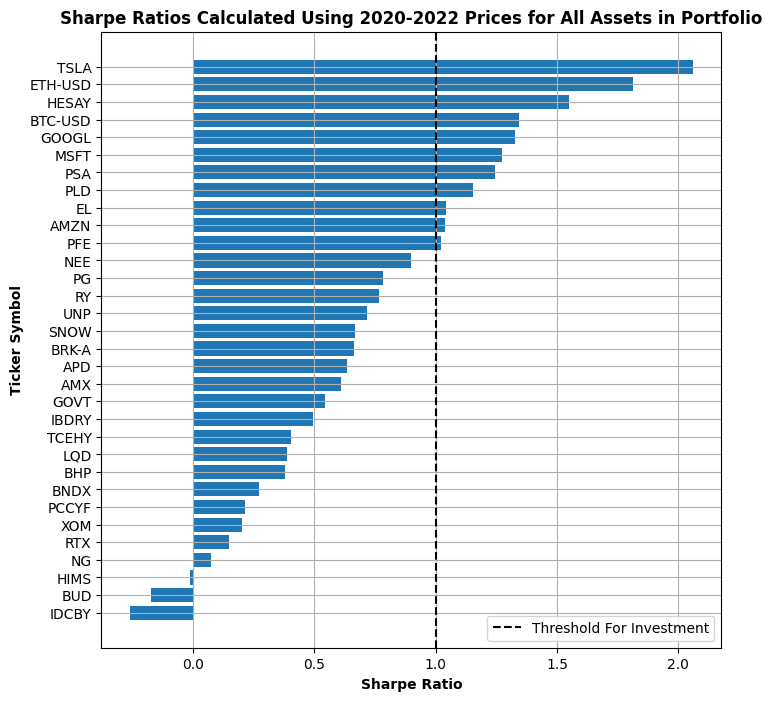

In [9]:
#sharpe_ratios = sharpe_ratios[sharpe_ratios['sharpe_ratio'] >= 0]
sharpe_ratios = sharpe_ratios.sort_values(by='sharpe_ratio')

plt.figure(figsize=(8, 8))
plt.barh(sharpe_ratios.ticker, sharpe_ratios.sharpe_ratio)
plt.axvline(1, ls='--', color='black', label='Threshold For Investment')
plt.xlabel('Sharpe Ratio', fontweight='bold')
plt.ylabel('Ticker Symbol', fontweight='bold')
plt.title('Sharpe Ratios Calculated Using 2020-2022 Prices for All Assets in Portfolio', fontweight='bold')
plt.legend()
plt.grid()
plt.show()

As you can see only, 11 out of the 31 investments included in the portfolio pass as a "good" or better investment opportnity. Given this analysis, there is likely room for improvement in which assets the portfolio continues to manage. 

# 5. Pricing Model: Alpha (CAPM)
## 5.1. Calculate Alpha 

* [Helpful resource](https://www.youtube.com/watch?v=-fCYZjNA7Ps&t=113s)

The last pricing model that is used in this work is known as the Capital Asset Pricing Model (CAPM). Through the capital asset pricing model, we can determine a value known as $\alpha$ for each asset in the portfolio, which provides a measure of the expected return of said asset relative to benchmark market performance. The formula for alpha is shown below:

$$
\begin{equation}
\alpha = R_f + \beta(R_m - R_f)
\end{equation}
$$

where:

* $R_f$ = Risk free rate
* $\beta$ = a value between calculated for most stocks/bonds that determines how correlated the asset is to the market as a whole. A value of 1 means that the asset is perfectly correlated with the behavior of the market. 
* $R_m$ = expected return of the market

In this case, we use the performance of the S&P 500 over the course of the pertinent period to calculate $R_m$ and pull precalculated beta values from the Yahoo Finance API. Doing so will allow us to calculate an alpha value for each asset in the portfolio:

** note that yahoo finance does not calculate $\beta$ values for the following assets, and as such are excluded from this portion of the analysis: SNOW, BTC-USD, ETH-USD.

In [10]:
baseline_returns = yf.Ticker('SPY').history(start=dt.date(2020, 1, 1), 
                                            end=dt.date(2022, 1, 1))['Close'].reset_index()
baseline_returns = baseline_returns.Close.pct_change()[1:]


alpha_data = []

for index, row in investments.iterrows():
    ticker = row['ticker']
    tmp = yf.Ticker(ticker)
    # using 2020 to 2022 as the new timeframe for a larger sample
    tmp = tmp.history(start=dt.date(2020, 1, 1), end=dt.date(2022, 1, 1))['Close'].reset_index()
    tmp_returns = tmp.Close.pct_change()[1:]
    try:
        a, b = np.polyfit(baseline_returns, tmp_returns, 1)
        alpha_data.append([ticker,a])
    except:
        continue

alpha_data = pd.DataFrame(alpha_data)
alpha_data = alpha_data.dropna()
alpha_data.columns = ['ticker', 'beta']
alpha_data = pd.merge(alpha_data, investments[['ticker', 'initial_investment']], how='inner', on='ticker')
alpha_data.head()

,ticker,beta,initial_investment
0,XOM,1.116984,400000
1,PCCYF,0.177016,400000
2,NEE,0.922521,200000
3,BHP,1.207274,100000
4,APD,1.019391,100000


In [11]:
baseline_returns = yf.Ticker('SPY').history(start=start_date, 
                                            end=end_date+relativedelta(days=1))['Close'].reset_index()
Rm = (baseline_returns['Close'].iloc[-1] - baseline_returns['Close'].iloc[0]) / baseline_returns['Close'].iloc[0]
print(f'Expected return of the market (using S&P 500): {Rm}')

Expected return of the market (using S&P 500): -0.0171088435280557


In [12]:
alpha_data['alpha'] = RISK_FREE_RATE + alpha_data['beta'] * (Rm - RISK_FREE_RATE)
alpha_data['predicted_position'] = (alpha_data['alpha'] + 1) * alpha_data['initial_investment']

final_returns = returns_data.iloc[-1].reset_index()
final_returns.columns = ['ticker', 'current_investment']
alpha_data = pd.merge(alpha_data, final_returns, how='inner', on='ticker')

alpha_data.head()

,ticker,beta,initial_investment,alpha,predicted_position,current_investment
0,XOM,1.116984,400000,-0.024620,390151.904457,373580.426102
1,PCCYF,0.177016,400000,0.035734,414293.593569,394444.41685
2,NEE,0.922521,200000,-0.012134,197573.201118,159701.065018
3,BHP,1.207274,100000,-0.030418,96958.232186,97167.379355
4,APD,1.019391,100000,-0.018354,98164.610855,95887.577043


## 5.2. Interpreting Alpha 

Below shows the values of $\alpha$ for each of the assets in the portfolio:

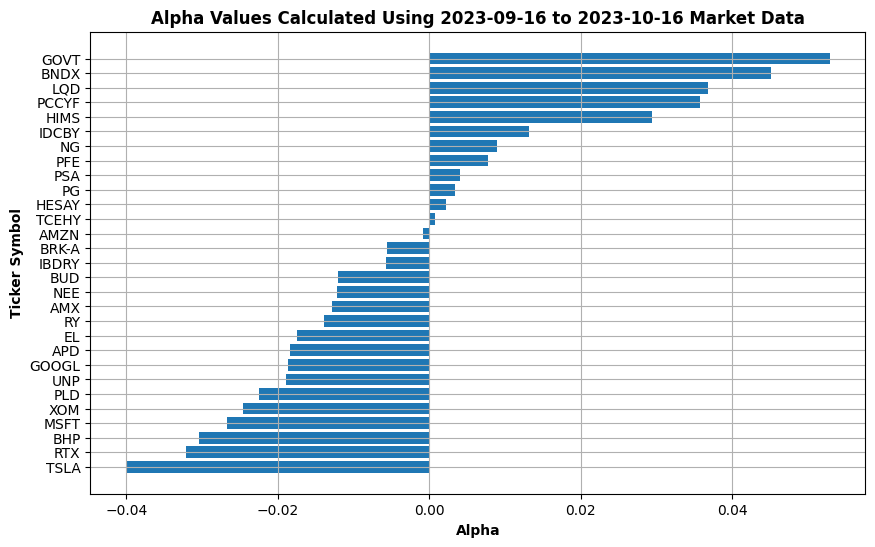

In [13]:
alpha_data = alpha_data.sort_values(by='alpha')

plt.figure(figsize=(10,6))
plt.barh(alpha_data.ticker, alpha_data.alpha)
plt.xlabel('Alpha', fontweight='bold')
plt.ylabel('Ticker Symbol', fontweight='bold')
plt.title('Alpha Values Calculated Using 2023-09-16 to 2023-10-16 Market Data', fontweight='bold')
plt.grid()

plt.show()

As you can see, most of the assets in the portfolio are expected to lose money using the capital asset pricing model. We can actually make a prediction of the total portfolio value using these $\alpha$ values if we treat them as expected rates of return for each asset:

In [14]:
alpha_start = alpha_data.initial_investment.sum()
alpha_end = alpha_data.predicted_position.sum()
actual_end = alpha_data.current_investment.sum()

print(f'Starting Portfolio value on 2023-09-16 (for assets included in this model): ${round(alpha_start, 2)}')
print('\n')
print(f'Predicted portfolio value by 2023-10-16: ${round(alpha_end, 2)}')
print(f'Predicted portfolio gain/loss by 2023-10-16: ${round(alpha_end - alpha_start)}')
print(f'Predicted portfolio gain/loss by 2023-10-16: {round((alpha_end - alpha_start) / alpha_start, 4)}%')
print('\n')
print(f'Actual portfolio value by 2023-10-16: ${round(actual_end, 2)}')
print(f'Actual portfolio gain/loss by 2023-10-16: ${round(actual_end - alpha_start)}')
print(f'Actual portfolio gain/loss by 2023-10-16: {round((actual_end - alpha_start) / alpha_start, 4)}%')


Starting Portfolio value on 2023-09-16 (for assets included in this model): $7400000


Predicted portfolio value by 2023-10-16: $7434206.84
Predicted portfolio gain/loss by 2023-10-16: $34207
Predicted portfolio gain/loss by 2023-10-16: 0.0046%


Actual portfolio value by 2023-10-16: $7078269.98
Actual portfolio gain/loss by 2023-10-16: $-321730
Actual portfolio gain/loss by 2023-10-16: -0.0435%


In this case, alpha's prediciton wasn't as bad as what happend to the actual value of the portfolio, but it did correctly predict that the portfolio would lose value. However, we can assume that in this case it was likely the portfolio would lose value because the value of the market decreased over the pertinent period ($R_m \approx -2.7$%). Given the current risk free rate, we can instead calculate the predicted portfolio value for different, hypothetical values of $R_m$: 

In [15]:
baseline_returns = yf.Ticker('SPY').history(start=dt.date(2020, 1, 1), 
                                            end=dt.date(2022, 1, 1))['Close'].reset_index()
baseline_returns = baseline_returns.Close.pct_change()[1:]


calc_alphas = []

for index, row in investments.iterrows():
    ticker = row['ticker']
    tmp = yf.Ticker(ticker)
    # using 2020 to 2022 as the new timeframe for a larger sample
    tmp = tmp.history(start=dt.date(2020, 1, 1), end=dt.date(2022, 1, 1))['Close'].reset_index()
    tmp_returns = tmp.Close.pct_change()[1:]
    try:
        a, b = np.polyfit(baseline_returns, tmp_returns, 1)
        calc_alphas.append([ticker,a])
    except:
        continue

calc_alphas = pd.DataFrame(calc_alphas)
calc_alphas = calc_alphas.dropna()
calc_alphas.columns = ['ticker', 'beta']
calc_alphas = pd.merge(calc_alphas, investments[['ticker', 'initial_investment']], how='inner', on='ticker')
calc_alphas.head()

,ticker,beta,initial_investment
0,XOM,1.116984,400000
1,PCCYF,0.177016,400000
2,NEE,0.922521,200000
3,BHP,1.207274,100000
4,APD,1.019390,100000


In [16]:
Rms = np.arange(-20, 20, 0.1)
predicted_values = []

for Rm in Rms:
    
    calc_alphas['alpha'] = RISK_FREE_RATE + calc_alphas['beta'] * ((Rm / 100) - RISK_FREE_RATE)
    calc_alphas['predicted_position'] = (calc_alphas['alpha'] + 1) * calc_alphas['initial_investment']
    predicted_value = calc_alphas.predicted_position.sum()
    predicted_values.append([Rm, predicted_value])

predicted_values = pd.DataFrame(predicted_values, columns = ['Rm', 'predicted_value'])
predicted_values['predicted_growth'] = (predicted_values['predicted_value'] - alpha_start) / alpha_start
predicted_values.head()

,Rm,predicted_value,predicted_growth
0,-20.0,6.538867e+06,-0.116369
1,-19.9,6.543762e+06,-0.115708
2,-19.8,6.548658e+06,-0.115046
3,-19.7,6.553553e+06,-0.114385
4,-19.6,6.558449e+06,-0.113723


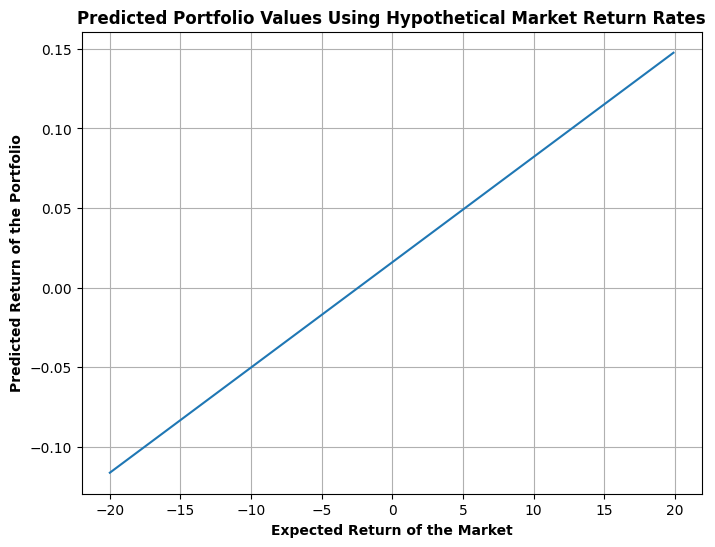

In [17]:
plt.figure(figsize=(8,6))
plt.plot(predicted_values.Rm, predicted_values.predicted_growth)
plt.xlabel('Expected Return of the Market', fontweight='bold')
plt.ylabel('Predicted Return of the Portfolio', fontweight='bold')
plt.title('Predicted Portfolio Values Using Hypothetical Market Return Rates', fontweight='bold')
plt.grid()
plt.show()

The graph above seems to indicate that the portolio could be improved if its intention is to focus on long term growth. After the market sees ~5% growth, the expected returns of the portfolio no longer outpace the expected returns of the market (i.e. by the time the market has grown 20%, the portfolio has only growth ~17%). As such, an argument can be made that a more successful portfolio would simply be one that invested wholly in a S&P 500 index fund. 

As an experiment, the cell below recreates the graph if we were to only includes assets in which the Sharpe ratio is greater than or equal to 1.

In [18]:
reallocation = pd.merge(calc_alphas, sharpe_ratios, how='inner', on='ticker')
reallocation = reallocation[reallocation['sharpe_ratio'] >= 1]
alpha_start = reallocation.initial_investment.sum()

for Rm in Rms:
    
    reallocation['alpha'] = RISK_FREE_RATE + reallocation['beta'] * ((Rm / 100) - RISK_FREE_RATE)
    reallocation['predicted_position'] = (reallocation['alpha'] + 1) * reallocation['initial_investment']
    predicted_value = reallocation.predicted_position.sum()
    predicted_values.append([Rm, predicted_value])

predicted_values = pd.DataFrame(predicted_values, columns = ['Rm', 'predicted_value'])
predicted_values['predicted_growth'] = (predicted_values['predicted_value'] - alpha_start) / alpha_start
predicted_values.head()

,Rm,predicted_value,predicted_growth
0,-20.0,6.538867e+06,2.534523
1,-19.9,6.543762e+06,2.537169
2,-19.8,6.548658e+06,2.539815
3,-19.7,6.553553e+06,2.542461
4,-19.6,6.558449e+06,2.545107


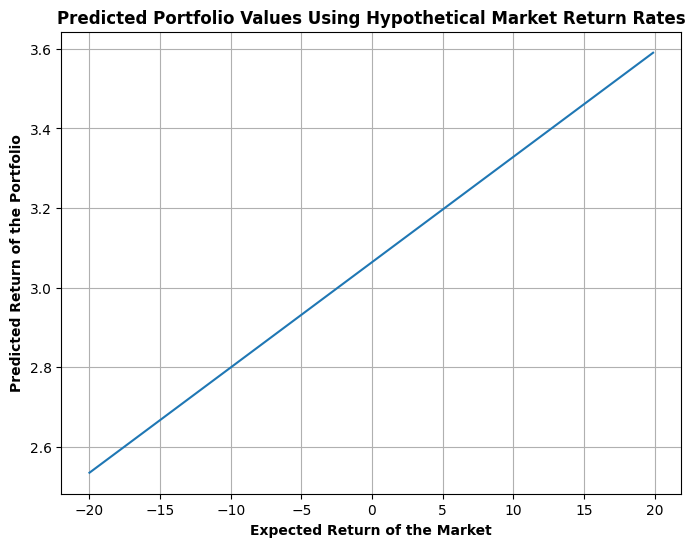

In [19]:
plt.figure(figsize=(8,6))
plt.plot(predicted_values.Rm, predicted_values.predicted_growth)
plt.xlabel('Expected Return of the Market', fontweight='bold')
plt.ylabel('Predicted Return of the Portfolio', fontweight='bold')
plt.title('Predicted Portfolio Values Using Hypothetical Market Return Rates', fontweight='bold')
plt.grid()
plt.show()

# Conclusion 

Given the results from all the evaluated pricing models, the CAPM $\alpha$ analysis seemed to provide the most useful insights. In summary, while the goal of this portfolio is to focus on long term growth, there are likely improvements that could be made in order to help maximize its potential gains. 